Data: https://opus.nlpl.eu/opus-100.php

In [1]:
import os
import time
import string
import itertools
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch.utils.data import DataLoader, Dataset

In [2]:
@dataclass
class Config:
    epochs:int = 100
    learning_rate:float = 3e-4
    batch_size:int = 256
    limit:int = 120000
    max_length_pl:int = 23
    max_length_en:int = 28
    embed_size:int = 256
    num_layers:int = 6
    heads:int = 8
    forward_expansion:int = 4
    dropout:int = 0.15
        
config = Config()    

In [3]:
@dataclass
class paths:
    data = os.path.join('data', 'en-pl')
    pl_test = os.path.join(data, 'opus.en-pl-test.pl')
    en_test = os.path.join(data, 'opus.en-pl-test.en')
    pl_dev = os.path.join(data, 'opus.en-pl-dev.pl')
    en_dev = os.path.join(data, 'opus.en-pl-dev.en')
    pl_train = os.path.join(data, 'opus.en-pl-train.pl')
    en_train = os.path.join(data, 'opus.en-pl-train.en')

In [4]:
class Vocabulary:
    def __init__(self, data):
        
        self.vocab = {
            '<unk>': 0,
            '<pad>': 1,
            '<sos>': 2,
            '<eos>': 3
        }
        
        self.build_vocab(data)
        
    def __getitem__(self, index):
        assert type(index) in [str, int], 'Index type must be string or int'
        
        if isinstance(index, str):
            try:
                return self.vocab[index]
            
            except KeyError:
                return self.vocab['<unk>']
        
        elif isinstance(index, int):
            try:
                return list(self.vocab.keys())[list(self.vocab.values()).index(index)]
            except (KeyError,ValueError):
                return self[0]
    
    def __len__(self):
        return len(self.vocab)
    
    def append_word(self, word):
        if not word in self.vocab and word.isalpha():
            self.vocab[word] = len(self)
    
    def build_vocab(self, data):
        bag_of_words = sorted(list(set(data)))
        
        for word in bag_of_words:
            self.append_word(word)

In [5]:
class PolEngDS(Dataset):
    def __init__(self, pl_path, en_path, limit=None):
        
        assert limit >= 0 and type(limit) == int, 'Limit has to be integer, >= 0.' 
        
        self.data = {
            'polish': self._load_data(pl_path),
            'english': self._load_data(en_path)
        }
        
        if limit:
            self.data['polish'] = self.data['polish'][:limit]
            self.data['english'] = self.data['english'][:limit]
            
        self.preprocessing()
        
        self.vocab_pl = Vocabulary(self._flat_list(self.data['polish']))
        self.vocab_en = Vocabulary(self._flat_list(self.data['english']))
        
    def __getitem__(self, index):
        pl, en = [text.split() for text in self.data.iloc[index].values]
        
        return [self.vocab_pl[word] for word in pl], [self.vocab_en[word] for word in en]
    
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def _load_data(path):
        with open(path, 'r', encoding='UTF-8') as f:
            data = f.read()
        data = data.split('\n')[:-1]
        
        return data
    
    def preprocessing(self):
        preprocessed_data = {
            'polish': [],
            'english': []
        }
        
        for i, (pl, en) in enumerate(zip(*self.data.values())):
            preprocessed_data['polish'].append(self._text_prep(pl))
            preprocessed_data['english'].append(self._text_prep(en))
        
        self.data = pd.DataFrame(preprocessed_data)
   
    @staticmethod
    def _text_prep(text):
        #remove punctuations
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.strip().lower()
        text.split('/n')
        
        return text
    
    @staticmethod
    def _flat_list(data):
        data = [text.split() for text in data]
        return list(itertools.chain.from_iterable(data))

In [6]:
train_data = PolEngDS(
    pl_path=paths.pl_train, 
    en_path=paths.en_train, 
    limit=config.limit
)

vocab_pl = train_data.vocab_pl
vocab_en = train_data.vocab_en

### Data analysis

In [7]:
lens_pl = train_data.data['polish'].apply(lambda x: len(x.split())).values
lens_en = train_data.data['english'].apply(lambda x: len(x.split())).values

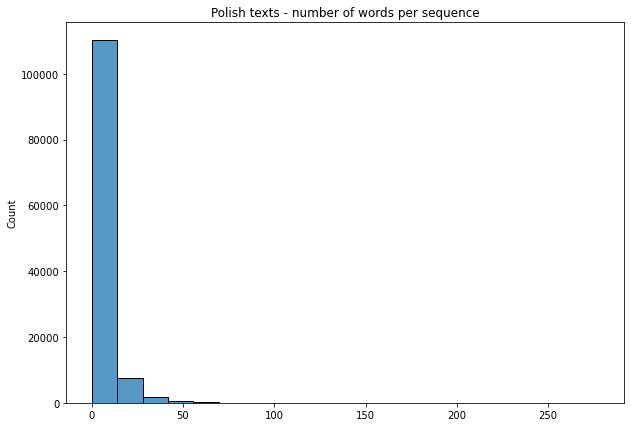

Percentile 98%: 27.0


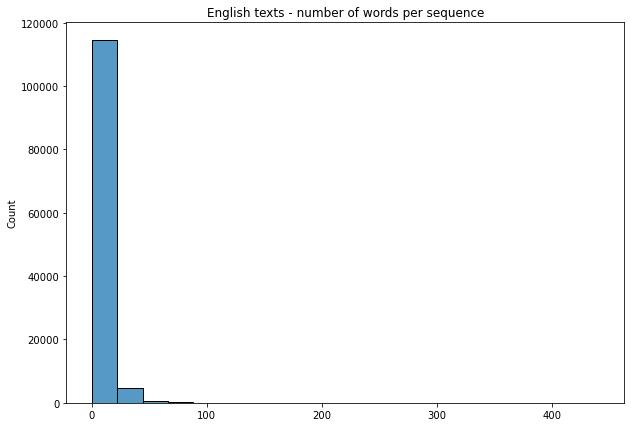

Percentile 98%: 32.0


In [8]:
plt.figure(figsize=(10, 7))
plt.title('Polish texts - number of words per sequence')
sns.histplot(lens_pl, bins=20)
plt.show()
print(F'Percentile 98%: {np.percentile(lens_pl, 98)}')

plt.figure(figsize=(10, 7))
plt.title('English texts - number of words per sequence')
sns.histplot(lens_en, bins=20)
plt.show()
print(F'Percentile 98%: {np.percentile(lens_en, 98)}')

### ...

In [9]:
def padding(text, vocab, max_len):
    text = [vocab['<sos>'], *text]
    text_len = len(text)

    if text_len >= (max_len + 1):
        text = text[:max_len + 1]
        text[-1] = vocab['<eos>']    
        
    else:
        text.append(vocab['<eos>'])
        pad_len = max_len - (text_len)

        for i in range(pad_len):
            text.append(vocab['<pad>'])
        
    return text

def pad_seq(batch, cfg):
    pl, en = [], []
    
    for i, (pl_text, en_text) in enumerate(batch):
        pl.append(torch.IntTensor(padding(pl_text, vocab_pl, max_len=cfg.max_length_pl)))
        en.append(torch.IntTensor(padding(en_text, vocab_en, max_len=cfg.max_length_en)))
        
    pl = torch.stack(pl)
    en = torch.stack(en)
    
    return pl, en

In [10]:
train_loader = DataLoader(
    train_data, 
    batch_size=config.batch_size, 
    collate_fn=lambda batch: pad_seq(batch, cfg=config), 
    shuffle=True,
#     num_workers=2,
#     pin_memory=True
)

In [11]:
#####

**Based on**:
    
    - https://arxiv.org/pdf/1706.03762.pdf
    - https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    - https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/transformer_from_scratch/transformer_from_scratch.py

In [12]:
class PositionalEncoder:
    def __init__(self, embed_size, n=10000):
        self.embed_size = embed_size
        self.n = n
        
    def positional_encoding(self, N, seq_len):
        n = torch.IntTensor([self.n])
        d = self.embed_size

        pos_enc = torch.zeros((seq_len, d))
        for j in range(seq_len):
            for i in range(int(d/2)):
                p = torch.pow(n, 2*i/d)
                
                pos_enc[j, 2*i] = torch.sin(j/p)
                pos_enc[j, 2*i+1] = torch.cos(j/p)

        pos_enc = pos_enc.expand(N, seq_len, d)

        return pos_enc
    
    def __call__(self, N, seq_len):
        return self.positional_encoding(N, seq_len)

In [13]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
        assert self.head_dim * self.heads == self.embed_size, 'Embed size needs to be divisible by heads'
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)
        
    def forward(self, values, keys, queries, mask):
        N = queries.shape[0]
        values_len, keys_len, queries_len = values.shape[1], keys.shape[1], queries.shape[1]
        
        # Split into self.heads number of heads
        values = values.reshape(N, values_len, self.heads, self.head_dim)
        keys = keys.reshape(N, keys_len, self.heads, self.head_dim)
        queries = queries.reshape(N, queries_len, self.heads, self.head_dim)
        
        # values shape after: (N, self.heads, values_len, self.head_dim)
        values = self.values(values).permute(0, 2, 1, 3) 
        
        # keys shape after: (N, self.heads, self.head_dim, keys_len)
        keys = self.keys(keys).permute(0, 2, 3, 1)
        
        # queries shape after: (N, self.heads, queries_len, self.head_dim)
        queries = self.queries(queries).permute(0, 2, 1, 3)
        
        # e shape after: (N, self.heads, queries_len, keys_len)
        e = (queries @ keys) / (self.embed_size**(1/2))

        if mask is not None:
            # if mask at same point is 0 - shutdown this point - set to -inf, in softmax it will be 0
            e = e.masked_fill(mask == 0, -1e20)

        attention = torch.softmax(e, dim=3)

        # out shape after: (N, self.heads, queries_len, self.head_dim)
        out = attention @ values

        out = out.reshape(N, queries_len, self.heads*self.head_dim)
        
        return out

In [14]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_size, forward_expansion, dropout):
        super(FeedForwardNetwork, self).__init__()
        
        self.fc_1 = nn.Linear(embed_size, embed_size*forward_expansion)
        self.fc_2 = nn.Linear(embed_size*forward_expansion, embed_size)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = F.gelu(self.fc_1(x))
        x = self.dropout(self.fc_2(x))
        
        return x

In [15]:
class Block(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout):
        super(Block, self).__init__()
        
        self.attention = SelfAttention(embed_size, heads)
        
        self.norm_1 = nn.LayerNorm(embed_size)
        self.norm_2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = FeedForwardNetwork(embed_size, forward_expansion, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, values, keys, queries, mask):
        attention = self.attention(values, keys, queries, mask)
        
        x = self.dropout(self.norm_1(attention + queries))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm_2(forward + x))
        
        return out

In [16]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        max_length,
        device
    ):

        super(Encoder, self).__init__()
        
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_encoding = PositionalEncoder(embed_size)
        
        self.layers = nn.ModuleList(
            [
                Block(
                    embed_size,
                    heads,
                    forward_expansion=forward_expansion,
                    dropout=dropout
                )
                
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_len = x.shape
        
        out = self.dropout(
            (self.word_embedding(x) + self.position_encoding(N, seq_len).to(self.device))
        )

        # In the Encoder the query, key, value are all the same, in the decoder it will change. 
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = Block(
            embed_size, heads, forward_expansion, dropout
        )
        
        self.norm = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        
        return out

In [18]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        max_length,
        device
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_encoding = PositionalEncoder(embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_len = x.shape
        
        x = self.dropout(
            (self.word_embedding(x) + self.position_encoding(N, seq_len).to(self.device))
        )

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out

In [19]:
class Model(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        heads=8,
        forward_expansion=4,
        dropout=0,
        max_length=100,
        device='cpu'
    ):

        super(Model, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            max_length,
            device
        ).to(device)
        
        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            max_length,
            device
        ).to(device)

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self._init_weights()
        
    def _init_weights(self):
        for mod in self.modules():
            if isinstance(mod, (nn.Linear, nn.Embedding)):
                torch.nn.init.normal_(mod.weight, mean=0.0, std=0.02)

                if isinstance(mod, nn.Linear) and mod.bias is not None:
                    torch.nn.init.zeros_(mod.bias)

            elif isinstance(mod, nn.LayerNorm):
                torch.nn.init.zeros_(mod.bias)
                torch.nn.init.ones_(mod.weight)

    def make_src_mask(self, src):
        # mask only vocab['<pad>'], because it shouldn't have an effect on output result
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # mask next words during decoding, decoder shouldn't have access to them 
        N, trg_len = trg.shape
        
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        enc_src = self.encoder(src, src_mask)
        
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        
        return out

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
model = Model(
    src_vocab_size=len(vocab_pl),
    trg_vocab_size=len(vocab_en),
    src_pad_idx=vocab_pl['<pad>'],
    trg_pad_idx=vocab_en['<pad>'],
    embed_size=config.embed_size,
    num_layers=config.num_layers,
    heads=config.heads,
    forward_expansion=config.forward_expansion,
    dropout=config.dropout,
    max_length=config.max_length_en,
    device=device
)

In [22]:
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()

In [23]:
wandb.init(
    project=f'PolEng translation - {time.time()}', 
    config=config.__dict__
)

wandb: Currently logged in as: jmisilo (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
wandb.watch(model, log_freq=50)

[]

In [25]:
def train_epoch(model, loader, epoch, device=device):
    model.train()
    
    losses = []
    t0 = time.time()
    t_batch = t0
    
    for batch_idx, (src, trg) in enumerate(loader):
        src = src.to(device)
        trg = trg.to(device)
        
        scores = model(src, trg[:, :-1])
        
        loss = criterion(scores.permute(0, 2, 1), trg[:, 1:].type(torch.long))
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()
        
        if (batch_idx + 1) % int(len(loader) / 5) == 0:
            print('Epoch: {epoch}, batch: {batch_idx}/{no_batches}, loss: {loss:.3f}, time: {t:.2f}'.format(
                epoch=epoch+1,
                batch_idx=batch_idx,
                no_batches=len(loader),
                loss=sum(losses)/len(losses),
                t=time.time()-t_batch
                )
            )
            
            t_batch = time.time()
        
    loss = sum(losses) / len(losses)
    
    print('Epoch: {epoch}, loss: {loss:.3f}, time: {t:.2f}'.format(
        epoch=epoch, 
        loss=loss, 
        t=time.time()-t0
        )
    )
    
    return loss

In [26]:
loss = []

for epoch in range(config.epochs):
    l = train_epoch(model, train_loader, epoch)
    loss.append(l)
    
    torch.save({
        'epoch': epoch,
        'model_sd': model.state_dict(),
        'optimizer_sd': optimizer.state_dict(),
        'loss': loss
       }, f'./models/checkpoint-{epoch}.pt')
    
    wandb.log({
        'loss': l
    })

In [27]:
def translate(
    sentence_pl, 
    model=model, 
    vocab_pl=vocab_pl, 
    vocab_en=vocab_en, 
    device=device, 
    max_length=50
):
    
    sentence_pl = [vocab_pl[word] for word in PolEngDS._text_prep(sentence_pl).split()]
    sentence_pl = [vocab_pl['<sos>'], *sentence_pl, vocab_pl['<eos>']]
    sentence_pl = torch.IntTensor(sentence_pl).unsqueeze(0)
    
    outputs = [vocab_en['<sos>']]
    
    model.eval()
    for i in range(max_length):
        sentence_en = torch.IntTensor(outputs).unsqueeze(0)
    
        with torch.no_grad():
            output = model(sentence_pl, sentence_en)
            
        prediction = output.argmax(2)[:, -1].item()
        outputs.append(prediction)

        if prediction == vocab_en['<eos>']:
            break
    
    sentence_en = [vocab_en[word] for word in outputs]
    
    model.train()
    
    return sentence_en